<a href="https://colab.research.google.com/github/DamodaraBarbosa/eleicoes_ceara_2022/blob/main/municipios_ceara_eleicao_2022_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import KMeans

In [2]:
RANDOM_SEED = 42

# 1. Carregando dados

In [3]:
# Dados referentes aos cargos disputados no estado do Ceará:

votacao_ce = pd.read_csv(
    '/content/drive/MyDrive/eleicoes_ceara_2022/votacao_secao_2022_CE_tratado.csv',
    encoding= 'latin-1', sep= ','
)

# Visualização das primeiras observações do dataframe:

votacao_ce.head()

,nm_municipio,nr_turno,nr_zona,nr_secao,ds_cargo,nr_votavel,nm_votavel,qt_votos
0,FORTALEZA,1,94,6,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,4
1,RUSSAS,1,9,266,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,13
2,PARAIPABA,1,109,119,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,3
3,ITAPIPOCA,1,17,25,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,2
4,SABOEIRO,1,43,228,DEPUTADO FEDERAL,4444,HEITOR RODRIGO PEREIRA FREIRE,4


In [7]:
# Dados referetes ao cargo de presidente da república:

presidente = pd.read_csv(
    '/content/drive/MyDrive/eleicoes_ceara_2022/votacao_secao_2022_BR_tratado.csv',
    encoding= 'latin-1', sep= ','
)

# Visualização das primeiras observações do dataframe:

presidente.head()

,nm_municipio,nr_turno,nr_zona,nr_secao,ds_cargo,nr_votavel,nm_votavel,qt_votos
0,JUCÁS,1,43,133,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,212
1,GRANJA,1,25,151,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,144
2,BATURITÉ,1,5,48,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,213
3,NOVA RUSSAS,1,48,176,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,148
4,FORTALEZA,1,94,706,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,169


In [8]:
# # Dados referetes aos indicadores do IBGE dos municípios cearenses:

# ibge_ce = pd.read_csv(
#     '/content/drive/MyDrive/Datasets/resumo_dados_ibge_ce.csv',
#     encoding= 'latin-1', sep= ','
# )


# # Visualização das primeiras observações do dataframe:

# ibge_ce.head()

# 2. *Clustering* dos dados com `KMeans`

## 2.1. Votos nos principais candidatos para diferentes cargos

O conjunto de dados que será passado para o algoritmo de *clustering* conterá:

> * Os **3 principais candidatos** ao cargo de **governador** do estado.
> * Os **3 principais candidatos** ao cargo de **senador** do estado.
> * Os **3 candidatos mais votados** para o cargo de **presidente** no estado.
> * Os **2 candidatos** que concorreram ao 2º turno ao cargo de **presidente** do país.

Para isso, os dados deverão ser tratados a fim conter apenas tais dados. Além disso, os votos serão expressos no **proporção de votos válidos** obtidos pelos candidatos para cada um dos municípios do estado.

> Isso se deve ao fato de **evitar distorções**, dado que há **municípios populosos** e outros **com população diminuta.**

As funções definidas abaixo têm como objetivo esse processamento dos dados.

In [9]:
def votos_validos_por_cidade(dataframe: pd.DataFrame, cargo: str, turno: int=1):
  """
  Calcula os votos válidos de todos os municípios do estado para os diferentes cargos.

  dataframe: objeto do tipo pandas.DataFrame com os dados da eleição.
  turno: turno da eleição em que se deseja buscar os dados. Default = 1.
  cargo: cargo ao qual deseja-se buscar os dados.
  """

  if turno not in [1, 2]:
    raise ValueError('Os valores aceitos pelo parâmetro turno são apenas 1 e 2, referentes ao 1º ou 2º turno da eleição.')
  else:
    votos_validos = dataframe.query('nm_votavel != ["VOTO BRANCO", "VOTO NULO"]') # contabilizam-se apenas os votos válidos.

    # Selecionam-se os dados por cargo disputado e turno da eleição, os votos válidos são agrupados por cidade e somados:

    votos_validos_por_cidade = votos_validos.query('ds_cargo == @cargo and nr_turno == @turno').groupby('nm_municipio')['qt_votos'].sum()
    dict_votos_validos_por_cidade = dict(votos_validos_por_cidade)

    if len(dict_votos_validos_por_cidade) == 0: # caso não exista determinado turno da eleição para um dos cargos, o dicionário estará vazio.
      n_turnos_no_dataframe = votos_validos['nr_turno'].unique()

      # E um erro será mostrado:

      raise ValueError(f'O dicionário encontra-se vazio. O nº de turnos na eleição para o {cargo} é: {n_turnos_no_dataframe}.')
    else:
      return dict_votos_validos_por_cidade

def porcentagem_de_votos(dataframe: pd.DataFrame, votos: dict, cargo: str, turno: int=1):
  """
  Calcula a porcentagem dos votos válidos de todos os municípios do estado para os principais candidatos aos cargos.

  dataframe: objeto do tipo pandas.DataFrame com os dados da eleição.
  votos: dicionário com os votos válidos por município para cada cargo na eleição.
  cargo: cargo ao qual deseja-se buscar os dados.
  turno: turno da eleição em que se deseja buscar os dados. Default = 1.
  """
  if turno not in [1, 2]:
    raise ValueError('Os valores aceitos pelo parâmetro turno são apenas 1 e 2, referentes ao 1º ou 2º turno da eleição.')
  else:
    votos_validos = dataframe.query('nm_votavel != ["VOTO BRANCO", "VOTO NULO"]') # contabilizam-se apenas os votos válidos.

    # Selecionam-se os dados por cargo disputado e turno da eleição, os votos válidos são agrupados por cidade e somados:

    votos_cargo_por_cidade = votos_validos.query('ds_cargo == @cargo and nr_turno == @turno').groupby(['nm_municipio', 'nm_votavel'])['qt_votos'].sum()

    # Ordem alfabética e em decrescente de votos:

    votos_cargo_por_cidade = votos_cargo_por_cidade.to_frame().sort_values(['nm_municipio', 'qt_votos'], ascending= [True, False])
    if turno == 2:
      votos_cargo_por_cidade = votos_cargo_por_cidade.groupby('nm_municipio').head(2)
    else:
      votos_cargo_por_cidade = votos_cargo_por_cidade.groupby('nm_municipio').head(3)

    votos_cargo_por_cidade = votos_cargo_por_cidade.reset_index()

    for row in votos_cargo_por_cidade.iterrows():
      index= row[0]
      qt_votos = row[1]['qt_votos']
      nome_municipio = row[1]['nm_municipio']

      porcentagem = qt_votos/votos[nome_municipio]
      votos_cargo_por_cidade.at[index, 'qt_votos'] = porcentagem

    if votos_cargo_por_cidade.shape[0] == 0: # caso não tenha ocorrido 2º turno para alguns do cargos, o dataframe estará vazio.
      n_turnos_no_dataframe = votos_validos['nr_turno'].unique()

      # E um erro será mostrado:

      raise ValueError(f'O dataframe encontra-se vazio. O nº de turnos na eleição para o {cargo} é: {n_turnos_no_dataframe}.')
    else:
      votos_cargo_por_cidade['nr_turno'] = turno # adiciona informação sobre o turno da eleição ao dataframe.
      votos_cargo_por_cidade['ds_cargo'] = cargo # adiciona informação sobre o cargo disputado ao dataframe.
      return votos_cargo_por_cidade

def formatar_dataframe(dataframe: pd.DataFrame, index: str, columns: str, values: str):
  """
  Formata o dataframe para deixá-lo no formato desejado para o clustering, ou seja, cada coluna representando a porcentagem de votos para os cargos
  disputados na eleição.
  dataframe: dataframe que será formatado.
  index: index do dataframe que será formatado.
  columns: informação que será convertida nas colunas do dataframe.
  values: valores que comporão as colunas do dataframe:
  """
  cargo = dataframe['ds_cargo'].unique()[0]
  turno = dataframe['nr_turno'].unique()[0]

  array_candidatos = dataframe['nm_votavel'].unique()
  list_candidatos_ordenados = sorted(list(array_candidatos)) # o array é transformado em lista e os candidatos são ordenados em ordem alfabética.
  new_dataframe = dataframe.pivot(index= index, columns= columns, values= values)

  # Uma lista com o nome dos candidatos é iterada de forma que as colunas conterão cargo disputado, turno da eleição e o 1º nome do candidato:

  new_dataframe.columns = [(cargo + '_' + f'{turno}_turno_' + candidato.split()[0]).lower() for candidato in list_candidatos_ordenados]
  new_dataframe = new_dataframe.reset_index()

  return new_dataframe

In [11]:
# Os votos válidos de cada município são contabilizados:

votos_validos_governador = votos_validos_por_cidade(votacao_ce, cargo= 'GOVERNADOR')
votos_validos_senador = votos_validos_por_cidade(votacao_ce, cargo= 'SENADOR')
votos_validos_presidente_1_turno = votos_validos_por_cidade(presidente, cargo= 'PRESIDENTE', turno=1)
votos_validos_presidente_2_turno = votos_validos_por_cidade(presidente, cargo= 'PRESIDENTE', turno=2)

In [12]:
# Dados referentes ao cargo de governador:

porcentagem_votos_governador = porcentagem_de_votos(votacao_ce, votos= votos_validos_governador, cargo= 'GOVERNADOR')
porcentagem_governador_por_cidade = formatar_dataframe(porcentagem_votos_governador, index= 'nm_municipio', columns= 'nm_votavel', values= 'qt_votos')
porcentagem_governador_por_cidade.head()

,nm_municipio,governador_1_turno_elmano,governador_1_turno_roberto,governador_1_turno_wagner
0,ABAIARA,0.793548,0.066983,0.137381
1,ACARAPE,0.502539,0.076483,0.420547
2,ACARAÚ,0.614294,0.046130,0.339067
3,ACOPIARA,0.637880,0.167552,0.193612
4,AIUABA,0.503980,0.362438,0.131343


In [13]:
# Dados referentes ao cargo de senador:

porcentagem_votos_senador = porcentagem_de_votos(votacao_ce, votos= votos_validos_senador, cargo= 'SENADOR')
porcentagem_senador_por_cidade = formatar_dataframe(porcentagem_votos_senador, index= 'nm_municipio', columns= 'nm_votavel', values= 'qt_votos')
porcentagem_senador_por_cidade.head()

,nm_municipio,senador_1_turno_camilo,senador_1_turno_erika,senador_1_turno_kamila
0,ABAIARA,0.894918,0.003644,0.101033
1,ACARAPE,0.634346,0.021611,0.344043
2,ACARAÚ,0.719278,0.006223,0.273957
3,ACOPIARA,0.732746,0.134316,0.132669
4,AIUABA,0.920011,0.013200,0.065998


In [15]:
# Dados referentes ao cargo de presidente no 1º turno:

porcentagem_votos_pres_1_turno = porcentagem_de_votos(dataframe= presidente, votos= votos_validos_presidente_1_turno, cargo= 'PRESIDENTE')
porcentagem_votos_pres_prim_turno = formatar_dataframe(porcentagem_votos_pres_1_turno, index= 'nm_municipio', columns= 'nm_votavel', values= 'qt_votos')
porcentagem_votos_pres_prim_turno.head()

,nm_municipio,presidente_1_turno_ciro,presidente_1_turno_jair,presidente_1_turno_luiz
0,ABAIARA,0.032145,0.104339,0.855437
1,ACARAPE,0.035048,0.324036,0.621734
2,ACARAÚ,0.059211,0.234469,0.694551
3,ACOPIARA,0.060203,0.132702,0.794262
4,AIUABA,0.051150,0.098706,0.839722


In [18]:
# Dados referentes ao cargo de presidente no 2º turno:

porcentagem_votos_pres_2_turno = porcentagem_de_votos(dataframe= presidente, votos= votos_validos_presidente_2_turno, cargo='PRESIDENTE', turno=2)
porcentagem_votos_pres_seg_turno = formatar_dataframe(porcentagem_votos_pres_2_turno, index='nm_municipio', columns='nm_votavel', values='qt_votos')
porcentagem_votos_pres_seg_turno.head()

,nm_municipio,presidente_2_turno_jair,presidente_2_turno_luiz
0,ABAIARA,0.126087,0.873913
1,ACARAPE,0.360237,0.639763
2,ACARAÚ,0.268728,0.731272
3,ACOPIARA,0.165870,0.834130
4,AIUABA,0.114966,0.885034


## 2.2. *Merge* dos *dataframes*

Define-se uma função para realizar o *merge* dos dataframes:

In [19]:
def merge_dataframes(left: pd.DataFrame, right: pd.DataFrame):
  """
  Realiza o merge entre dois dataframes.
  left: dataframe incorporador.
  right: dataframe incorporado.
  """
  dataframe_merged = pd.merge(left=left, right=right, how='inner', left_on='nm_municipio', right_on='nm_municipio')

  return dataframe_merged

In [20]:
dados_eleicao = porcentagem_governador_por_cidade # dataframe incorporador.
dados_eleicao = merge_dataframes(dados_eleicao, porcentagem_senador_por_cidade) # dados do cargo de senador.
dados_eleicao = merge_dataframes(dados_eleicao, porcentagem_votos_pres_prim_turno) # dados 1º turno para presidente.
dados_eleicao = merge_dataframes(dados_eleicao, porcentagem_votos_pres_seg_turno) # dados 2º turno para presidente.

In [21]:
dados_eleicao.head()

,nm_municipio,governador_1_turno_elmano,governador_1_turno_roberto,governador_1_turno_wagner,senador_1_turno_camilo,senador_1_turno_erika,senador_1_turno_kamila,presidente_1_turno_ciro,presidente_1_turno_jair,presidente_1_turno_luiz,presidente_2_turno_jair,presidente_2_turno_luiz
0,ABAIARA,0.793548,0.066983,0.137381,0.894918,0.003644,0.101033,0.032145,0.104339,0.855437,0.126087,0.873913
1,ACARAPE,0.502539,0.076483,0.420547,0.634346,0.021611,0.344043,0.035048,0.324036,0.621734,0.360237,0.639763
2,ACARAÚ,0.614294,0.046130,0.339067,0.719278,0.006223,0.273957,0.059211,0.234469,0.694551,0.268728,0.731272
3,ACOPIARA,0.637880,0.167552,0.193612,0.732746,0.134316,0.132669,0.060203,0.132702,0.794262,0.165870,0.834130
4,AIUABA,0.503980,0.362438,0.131343,0.920011,0.013200,0.065998,0.051150,0.098706,0.839722,0.114966,0.885034


## 2.3. Análise de correlação entre as variáveis

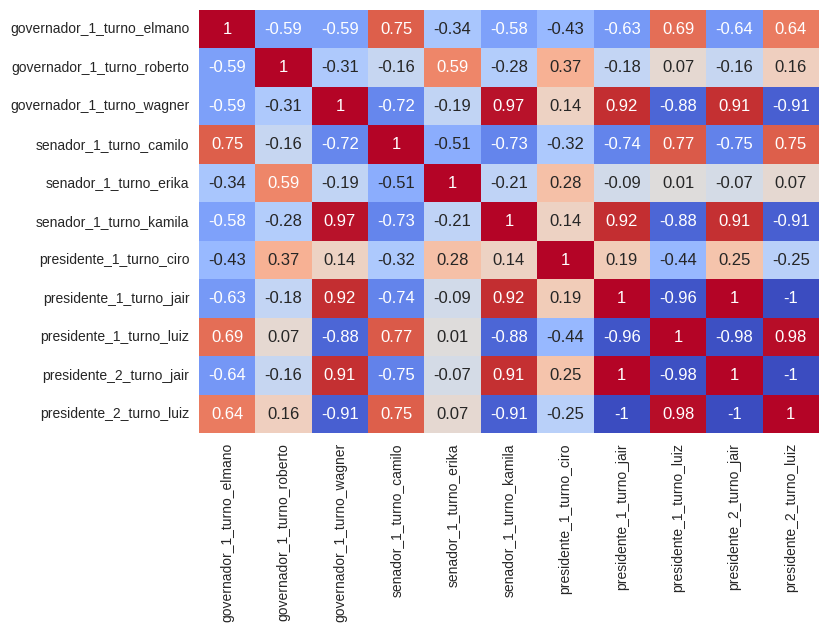

In [22]:
ax = sns.heatmap(data= dados_eleicao.corr(numeric_only=True).round(2), annot=True, cbar= False, cmap='coolwarm')
plt.show()

Algumas correlações que se destacam:

> * **Correlação positiva moderada** entre o governador eleito **Elmano** e o senador eleito **Camilo** e o presidente eleito **Lula** nos **dois turnos.** Em contrapartida, há uma correlação negativa entre os demais candidatos ao governo do estado, os demais candidatos ao senado e ao cargo de presidente.
> * **Correlação positiva moderada** entre o senador eleito **Camilo** e o governador eleito **Elmano** e o presidente eleito **Lula** nos **dois turnos.** Em contrapartida, há uma correlação negativa entre os demais candidatos ao governo, os demais candidatos ao senado e ao cargo de presidente.
> * **Correlação positiva forte** entre o candidato **Jair Bolsonaro** e os candidatos ao estado e ao senado, respectivamente, **Wagner e Kamila.**
> A correlação entre os votos nos candidatos **Jair Bolsonaro e Lula** é **negativamente quase perfeita** tanto no **1º quanto 2º turno.**
> Há **correlação positiva fraca** entre o candidato **Ciro Gomes** e o candidato **Jair Bolsonaro** nos dois turnos da eleição, no 2º turno essa correlação é acrescida.

## 2.4. Redução de dimensionalidade com PCA

O conjunto de dados após o *merge* contém 12 colunas. Portanto, pode ser feita uam redução de dimensionalidade, ou seja, reduzir o número de colunas.

> A técnica *Principal Component Analysis* (PCA) transforma um conjunto de variáveis em um novo conjunto conhecido como compenentes principais. Ou seja, é uma combinação das variáveis originais.

Além de reduzir a dimensionalidade, o PCA também pode ser útil para facilitar a visualização dos dados.

In [23]:
# O PCA é instanciado e os dados são transformados e armezenados numa nova variável:

pca = PCA(n_components= 2)
dados_pca = pca.fit_transform(dados_eleicao.drop('nm_municipio', axis= 1))

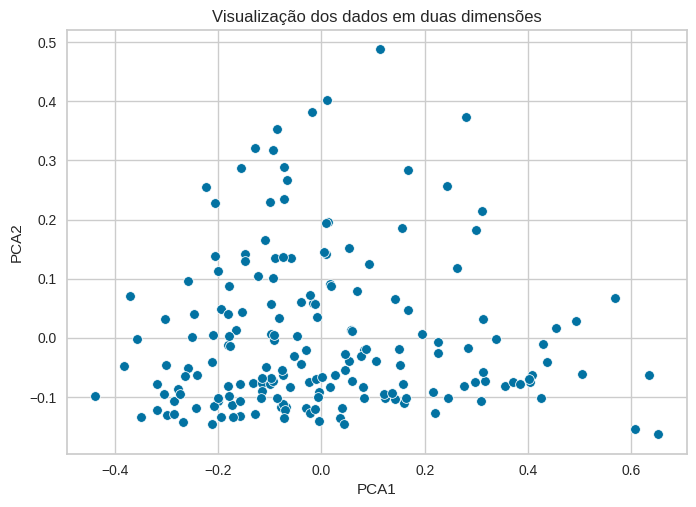

In [24]:
ax = sns.scatterplot(x= dados_pca[:, 0], y= dados_pca[:, 1])
ax.set_title('Visualização dos dados em duas dimensões')
ax.set_ylabel('PCA2')
ax.set_xlabel('PCA1')
plt.show()

Para verificar se os componentes principais explicam bem a variância em relação à variância total:

In [25]:
pca.explained_variance_ratio_

array([0.67200915, 0.23190765])

> A a proporção da variância dos componentes principais explica **90%** da variância total.

## 2.5. Definição do número adequado de *clusters*

Para definir o número ideal de *clusters* algumas técnicas podem ser usadas como o método *Elbow* e *Silhouette*. O mais comum é o primeiro. No método *Elbow* plota-se um gráfico com o número de *clusters* no eixo *x* e no eixo *y* uma métrica de distorção que é a soma das distâncias quadradas entre os pontos dos dados e seus respectivos centróides.

> A quantidade adequada de *clusters* é determinada pela visualização gráfica, sendo esse o ponto de inflexão do gráfico, ou seja, "o cotovelo", parte do corpo ao qual o nome do método se refere.

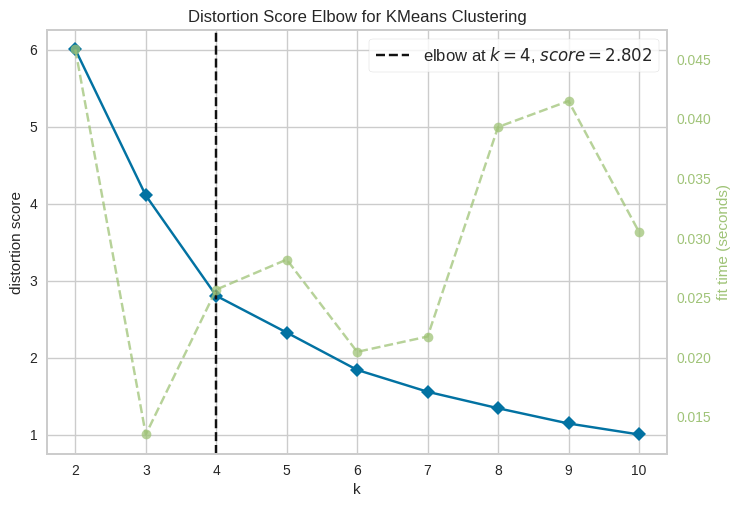

In [26]:
elbow = KElbowVisualizer(KMeans(init='k-means++', max_iter=100, n_init=10, random_state=RANDOM_SEED), k=10)
elbow.fit(dados_pca)
elbow.show()
sns.set_style('white')

## 2.6. Ajuste do modelo de *clustering*

O algoritmo de clusterização *KMeans* funciona a partir de um número *k* de *clusters* definido **previamente**, após isso o algoritmo determina **valores para os centróides** e os valores **mais próximos** aos centróides formam um *cluster*. Há uma iteração, portanto, tal processo **se repete** até que os centróides **parem de se deslocar.**

In [27]:
kmeans = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 300, n_init=10, random_state=RANDOM_SEED)
clusters = kmeans.fit_predict(dados_pca)

In [28]:
# Posição dos centróides:

centroides = pd.DataFrame({'x': kmeans.cluster_centers_[:, 0], 'y': kmeans.cluster_centers_[:, 1]})
centroides

,x,y
0,-0.035216,0.227881
1,0.369023,-0.034451
2,-0.225661,-0.057046
3,0.013775,-0.047453


In [29]:
# Rótulos para cada ponto de dados:

labels = kmeans.labels_
labels

array([2, 1, 3, 0, 0, 0, 2, 2, 3, 0, 0, 1, 1, 3, 3, 2, 3, 0, 2, 3, 0, 0,
       3, 1, 2, 0, 3, 3, 3, 2, 0, 0, 2, 3, 3, 2, 3, 3, 2, 1, 1, 2, 2, 1,
       0, 2, 3, 3, 3, 3, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 0, 3, 2, 2, 2, 1,
       3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 1, 3, 1, 3,
       3, 1, 2, 2, 3, 3, 1, 2, 0, 1, 3, 3, 0, 3, 2, 1, 1, 1, 2, 3, 3, 3,
       2, 0, 2, 2, 3, 0, 3, 3, 1, 2, 3, 2, 3, 2, 3, 0, 1, 1, 3, 2, 1, 3,
       1, 1, 3, 3, 2, 0, 3, 2, 3, 2, 0, 2, 0, 2, 2, 2, 1, 0, 0, 3, 3, 0,
       3, 2, 0, 0, 2, 2, 3, 3, 1, 2, 3, 1, 0, 3, 2, 2, 2, 0, 3, 1, 3, 3,
       1, 0, 0, 3, 3, 0, 3, 2], dtype=int32)

## 2.7. Visualização dos dados com os *clusters* definidos

In [30]:
# Uma coluna com os clusters é adicionada ao dataframe:

dados_eleicao['pca_1'] = dados_pca[:, 0]
dados_eleicao['pca_2'] = dados_pca[:, 1]
dados_eleicao['clusters'] = labels

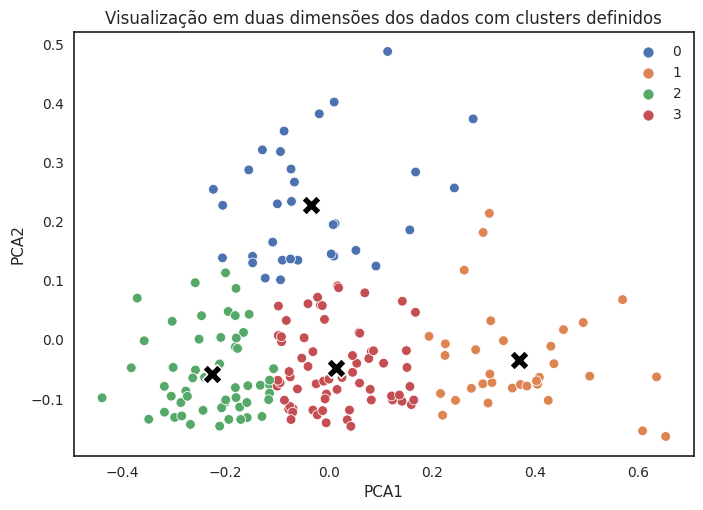

In [31]:
ax = sns.scatterplot(x= dados_pca[:, 0], y= dados_pca[:, 1], hue= labels, palette= 'deep')
ax.set_title('Visualização em duas dimensões dos dados com clusters definidos')
sns.scatterplot(data=centroides, x='x', y='y', marker= 'X', s= 200, color= 'black')
ax.set_ylabel('PCA2')
ax.set_xlabel('PCA1')
plt.show()

# 3. Análise do perfil de votação para cada *cluster*

## 3.1. Para o cargo de governador do estado

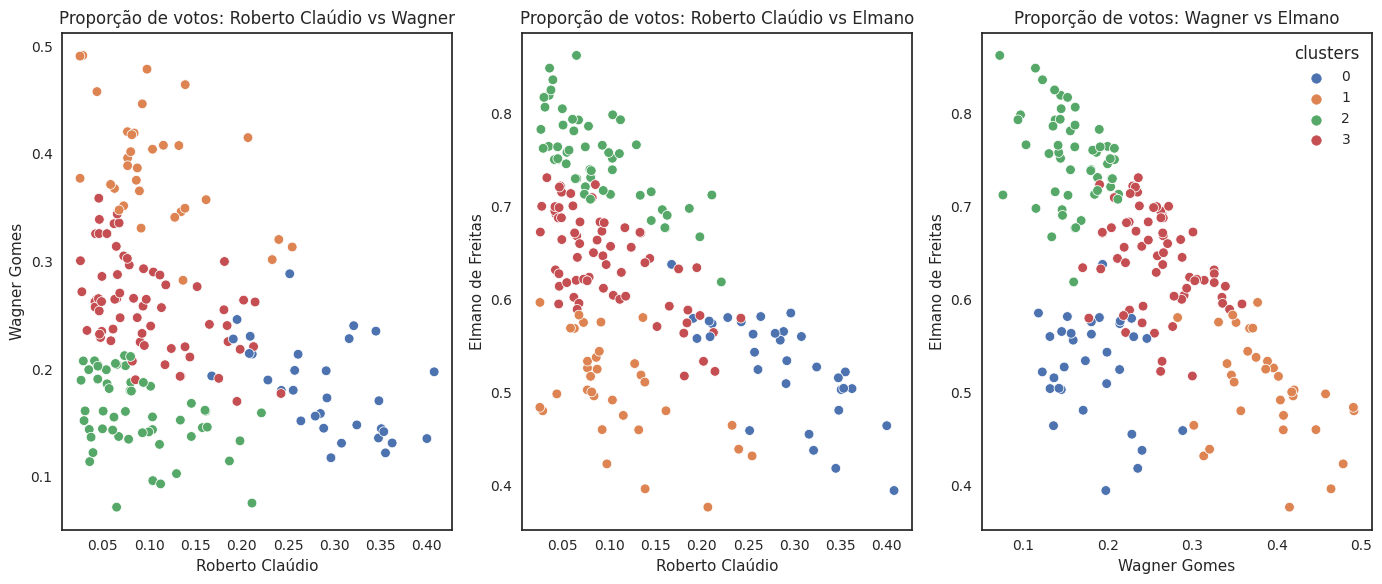

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

ax1 = sns.scatterplot(
    data=dados_eleicao, x='governador_1_turno_roberto', y='governador_1_turno_wagner',
    legend=False, hue='clusters', palette='deep', ax=ax[0]
)
ax1.set_title('Proporção de votos: Roberto Claúdio vs Wagner')
ax1.set_xlabel('Roberto Claúdio')
ax1.set_ylabel('Wagner Gomes')
ax2 = sns.scatterplot(
    data=dados_eleicao, x='governador_1_turno_roberto', y='governador_1_turno_elmano',
    legend=False, hue='clusters', palette='deep', ax=ax[1]
)
ax2.set_title('Proporção de votos: Roberto Claúdio vs Elmano')
ax2.set_xlabel('Roberto Claúdio')
ax2.set_ylabel('Elmano de Freitas')
ax3 = sns.scatterplot(
    data=dados_eleicao, x='governador_1_turno_wagner', y='governador_1_turno_elmano',
    hue='clusters', palette='deep', ax=ax[2]
)
ax3.set_title('Proporção de votos: Wagner vs Elmano')
ax3.set_xlabel('Wagner Gomes')
ax3.set_ylabel('Elmano de Freitas')
plt.tight_layout()
plt.show()

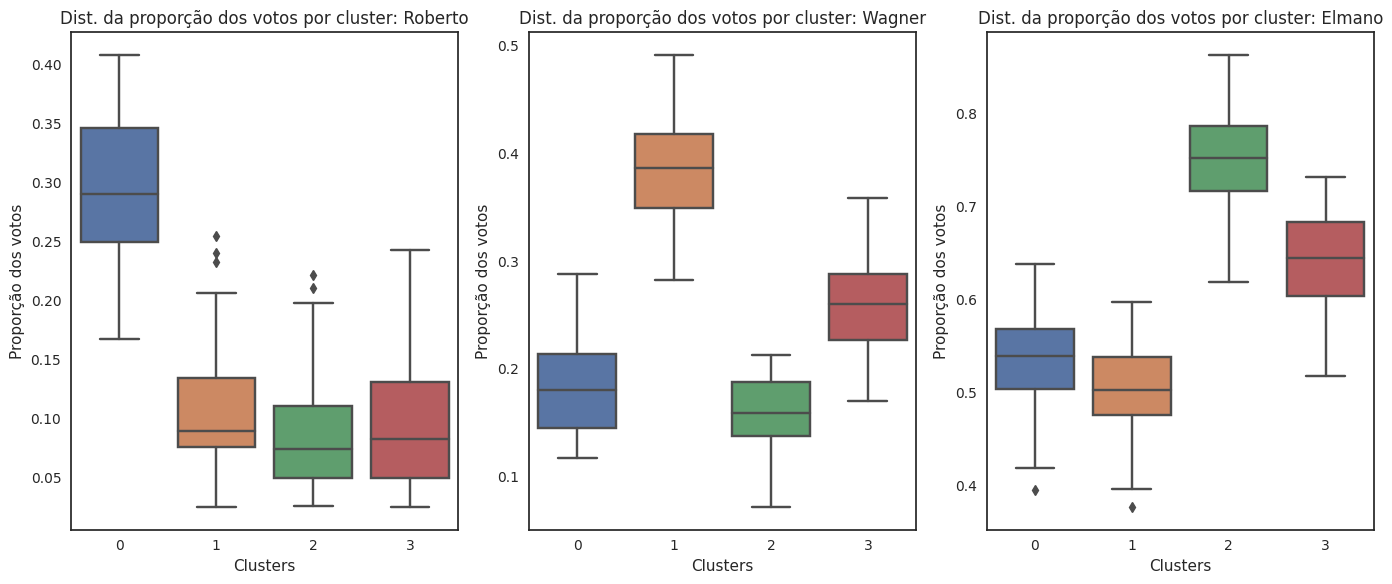

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

ax1 = sns.boxplot(
    data=dados_eleicao, x='clusters' , y='governador_1_turno_roberto',
    palette='deep', ax=ax[0]
)
ax1.set_title('Dist. da proporção dos votos por cluster: Roberto')
ax1.set_xlabel('Clusters')
ax1.set_ylabel('Proporção dos votos')
ax2 = sns.boxplot(
    data=dados_eleicao, x='clusters' , y='governador_1_turno_wagner',
    palette='deep', ax=ax[1]
)
ax2.set_title('Dist. da proporção dos votos por cluster: Wagner')
ax2.set_xlabel('Clusters')
ax2.set_ylabel('Proporção dos votos')
ax3 = sns.boxplot(
    data=dados_eleicao, x='clusters' , y='governador_1_turno_elmano',
    palette='deep', ax=ax[2]
)
ax3.set_title('Dist. da proporção dos votos por cluster: Elmano')
ax3.set_xlabel('Clusters')
ax3.set_ylabel('Proporção dos votos')
plt.tight_layout()
plt.show()

Ao analisar os gráficos de dispersão e os *boxplots* com dados referentes aos cadidatos à governador:

* **Cluster 0:**
> Cidades onde o candidato **Roberto Claúdio** obteve **seu melhor desempenho eleitoral.** É um dos *clusters* com os **piores desempenhos** para os **outros dois candidatos concorrentes.**

* **Cluster 1:**
> Cidades com **melhor desempenho eleitoral** do candidato **Wagner Gomes**. Também são as cidades com **pior desempenho** para o candidato eleito **Elmano de Freitas.** Apesar disso, é o único onde há um **equilíbrio de votos nos dois candidatos.**

* **Cluster 2:**
> Cidades com os **piores desempenhos** para **Roberto Claúdio e Wagner Gomes**, e o **maior desempenho eleitoral** para o candidato eleito **Elmano de Freitas.**

* **Cluster 3:**
> Cidades com **desempenhos mais intermediários** para os **3 candidatos.**

## 3.2. Para o cargo de senador do estado

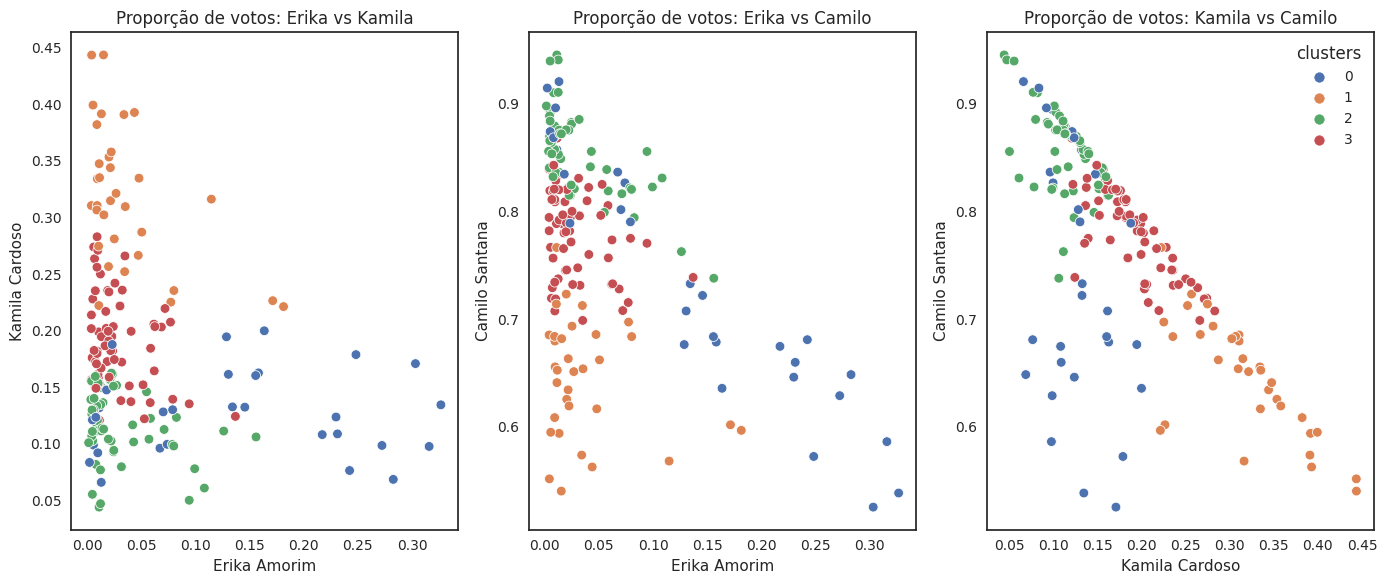

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

ax1 = sns.scatterplot(
    data=dados_eleicao, x='senador_1_turno_erika', y='senador_1_turno_kamila',
    legend=False, hue='clusters', palette='deep', ax=ax[0]
)
ax1.set_title('Proporção de votos: Erika vs Kamila')
ax1.set_xlabel('Erika Amorim')
ax1.set_ylabel('Kamila Cardoso')
ax2 = sns.scatterplot(
    data=dados_eleicao, x='senador_1_turno_erika', y='senador_1_turno_camilo',
    legend=False, hue='clusters', palette='deep', ax=ax[1]
)
ax2.set_title('Proporção de votos: Erika vs Camilo')
ax2.set_xlabel('Erika Amorim')
ax2.set_ylabel('Camilo Santana')
ax3 = sns.scatterplot(
    data=dados_eleicao, x='senador_1_turno_kamila', y='senador_1_turno_camilo',
    hue='clusters', palette='deep', ax=ax[2]
)
ax3.set_title('Proporção de votos: Kamila vs Camilo')
ax3.set_xlabel('Kamila Cardoso')
ax3.set_ylabel('Camilo Santana')
plt.tight_layout()
plt.show()

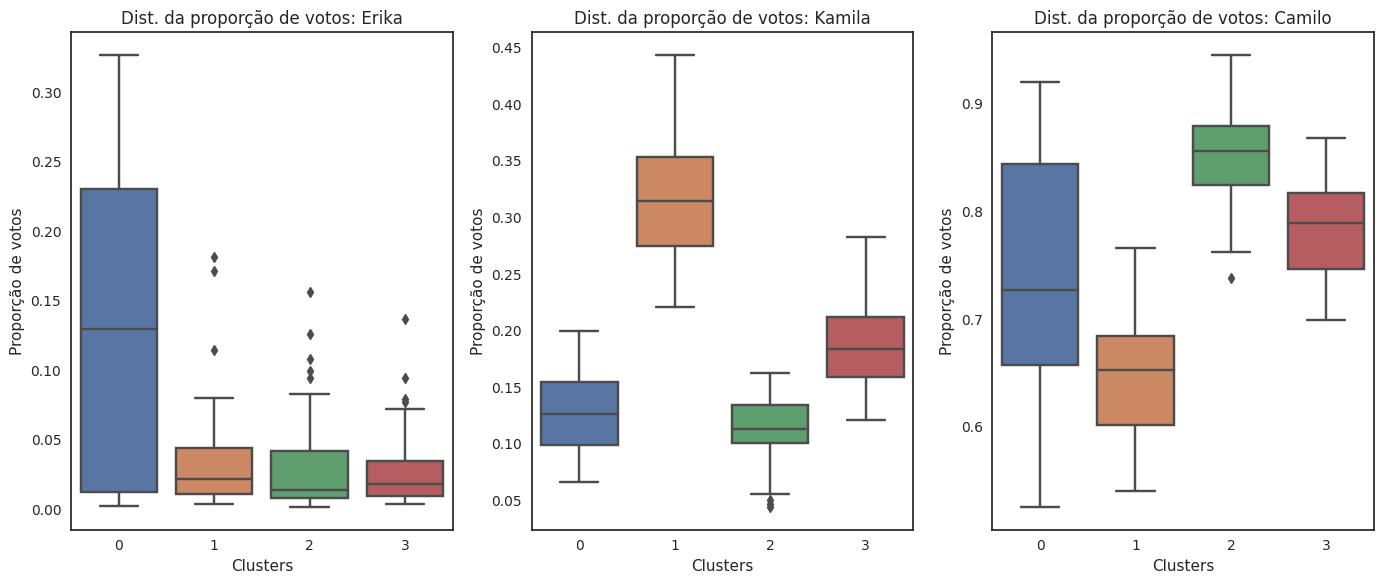

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

ax1 = sns.boxplot(
    data=dados_eleicao, x='clusters', y='senador_1_turno_erika',
    palette='deep', ax=ax[0]
)
ax1.set_title('Dist. da proporção de votos: Erika')
ax1.set_xlabel('Clusters')
ax1.set_ylabel('Proporção de votos')
ax2 = sns.boxplot(
    data=dados_eleicao, x='clusters', y='senador_1_turno_kamila',
    palette='deep', ax=ax[1]
)
ax2.set_title('Dist. da proporção de votos: Kamila')
ax2.set_xlabel('Clusters')
ax2.set_ylabel('Proporção de votos')
ax3 = sns.boxplot(
    data=dados_eleicao, x='clusters', y='senador_1_turno_camilo',
    palette='deep', ax=ax[2]
)
ax3.set_title('Dist. da proporção de votos: Camilo')
ax3.set_xlabel('Clusters')
ax3.set_ylabel('Proporção de votos')
plt.tight_layout()
plt.show()

Ao analisar os gráficos de dispersão e os *boxplots* com dados referentes aos cadidatos ao senado:

* **Cluster 0:**
> É o cluster dos municípios com melhor desempenho eleitoral da candidata **Erika Amorim.** Mas também um dos **piores desempenhos** da candidata **Kamila Cardoso.**

* **Cluster 1:**
> Cidades com **melhor desempenho eleitoral** da candidata **Kamila Cardoso**. Também são as cidades com **pior desempenho** para o candidato eleito **Camilo Santana.** É, portanto, o *cluster* onde a **diferença de votos** entre os dois candidatos é **menor.**

* **Cluster 2:**
> Cidades com os **piores desempenhos** para **Erika Amorim e Kamila Cardoso**, e o **maior desempenho eleitoral** para o candidato eleito **Camilo Santana.**

* **Cluster 3:**
> Cidades com **desempenhos mais intermediários** para os candidatos **Kamila Cardoso e Camilo Santana.** O desempenho nesse *cluster* para a candidata **Erika Amorim** não se diferencia tanto dos *clusters* 1 e 2.

## 3.3. Para o cargo de presidente no 1º turno

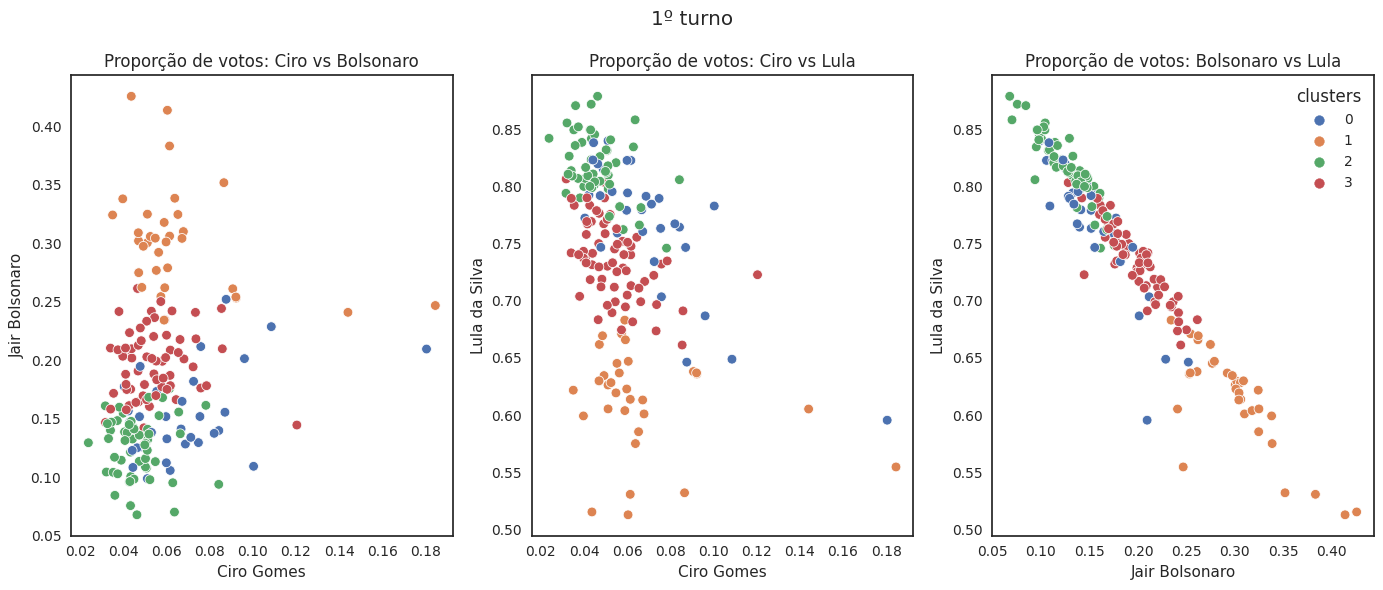

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('1º turno')

ax1 = sns.scatterplot(
    data=dados_eleicao, x='presidente_1_turno_ciro', y='presidente_1_turno_jair',
    legend=False, hue='clusters', palette='deep', ax=ax[0]
)
ax1.set_title('Proporção de votos: Ciro vs Bolsonaro')
ax1.set_xlabel('Ciro Gomes')
ax1.set_ylabel('Jair Bolsonaro')
ax2 = sns.scatterplot(
    data=dados_eleicao, x='presidente_1_turno_ciro', y='presidente_1_turno_luiz',
    legend=False, hue='clusters', palette='deep', ax=ax[1]
)
ax2.set_title('Proporção de votos: Ciro vs Lula')
ax2.set_xlabel('Ciro Gomes')
ax2.set_ylabel('Lula da Silva')
ax3 = sns.scatterplot(
    data=dados_eleicao, x='presidente_1_turno_jair', y='presidente_1_turno_luiz',
    hue='clusters', palette='deep', ax=ax[2]
)
ax3.set_title('Proporção de votos: Bolsonaro vs Lula')
ax3.set_xlabel('Jair Bolsonaro')
ax3.set_ylabel('Lula da Silva')
plt.tight_layout()
plt.show()

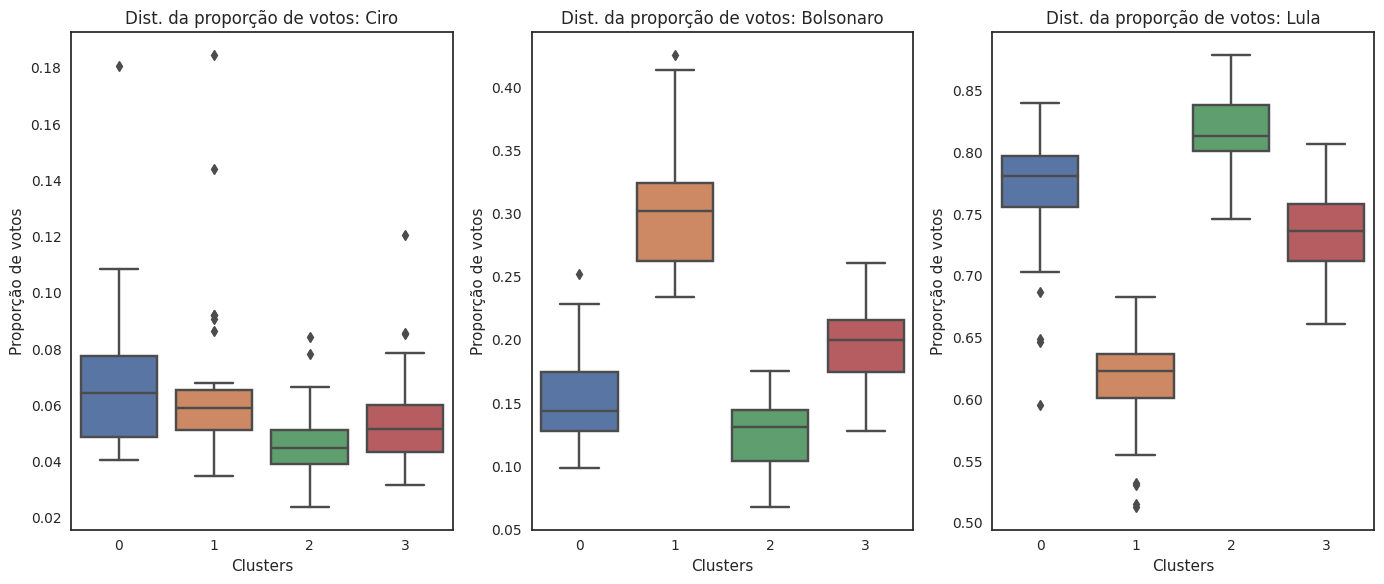

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

ax1 = sns.boxplot(
    data=dados_eleicao, x='clusters', y='presidente_1_turno_ciro',
    palette='deep', ax=ax[0]
)
ax1.set_title('Dist. da proporção de votos: Ciro')
ax1.set_xlabel('Clusters')
ax1.set_ylabel('Proporção de votos')
ax2 = sns.boxplot(
    data=dados_eleicao, x='clusters', y='presidente_1_turno_jair',
    palette='deep', ax=ax[1]
)
ax2.set_title('Dist. da proporção de votos: Bolsonaro')
ax2.set_xlabel('Clusters')
ax2.set_ylabel('Proporção de votos')
ax3 = sns.boxplot(
    data=dados_eleicao, x='clusters', y='presidente_1_turno_luiz',
    palette='deep', ax=ax[2]
)
ax3.set_title('Dist. da proporção de votos: Lula')
ax3.set_xlabel('Clusters')
ax3.set_ylabel('Proporção de votos')
plt.tight_layout()
plt.show()

Ao analisar os gráficos de dispersão e os *boxplots* com dados referentes aos cadidatos à presidência no 1º turno:

* **Cluster 0:**
> Municípios com **bom desempenho** do candidato eleito **Lula**, **desempenho baixo de Bolsonaro** e **bom desempenho** do candidato **Ciro.**

* **Cluster 1:**
> Cidades com **melhor desempenho eleitoral** do candidato **Jair Bolsonaro**. Também são as cidades com **pior desempenho** para o candidato eleito **Lula da Silva.** É, portanto, o *cluster* onde a **diferença de votos** entre os dois candidatos é **menor.**

* **Cluster 2:**
> Cidades com os **piores desempenhos** para **Ciro Gomes e Jair Bolsonaro**, e o **maior desempenho eleitoral** para o candidato eleito **Lula da Silva.**

* **Cluster 3:**
> Cidades com **desempenhos mais intermediários** para os candidatos **Jair Bolsonaro e Lula da Silva.** O desempenho nesse *cluster* para o candidato **Ciro Gomes** é fraco.

## 3.4. Para o cargo de presidente no 2º turno

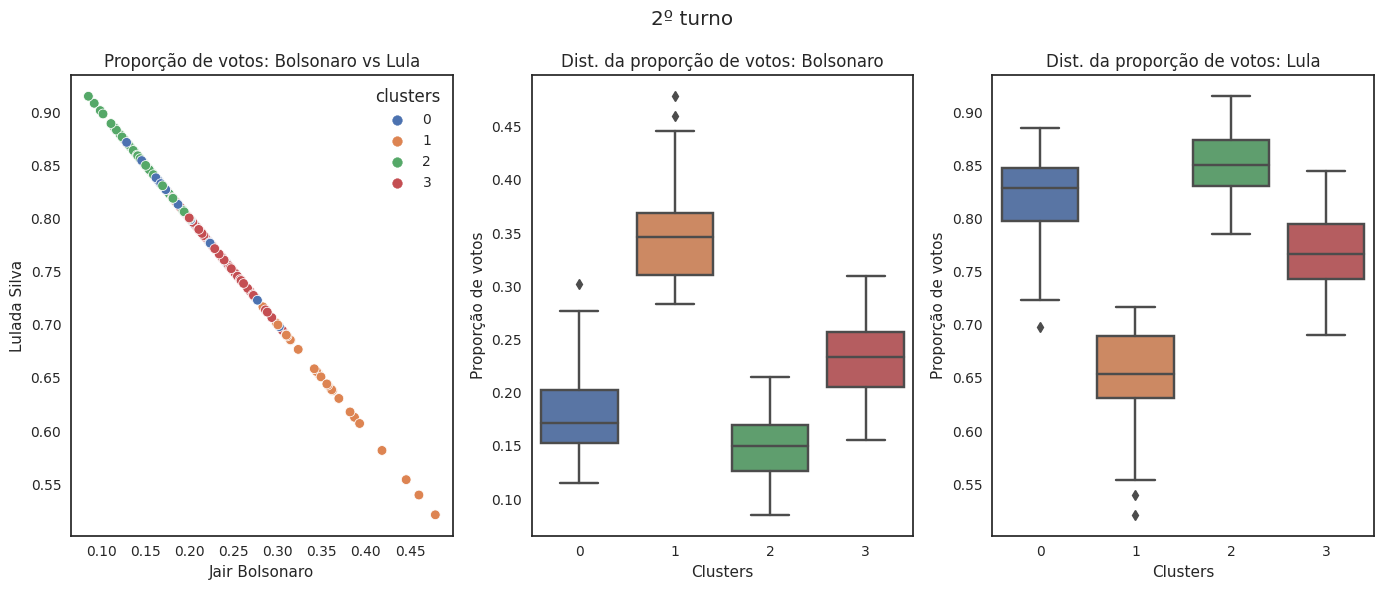

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('2º turno')

ax1 = sns.scatterplot(
    data=dados_eleicao, x='presidente_2_turno_jair', y='presidente_2_turno_luiz',
    hue='clusters', palette='deep', ax=ax[0]
)
ax1.set_title('Proporção de votos: Bolsonaro vs Lula')
ax1.set_xlabel('Jair Bolsonaro')
ax1.set_ylabel('Lulada Silva')
ax2 = sns.boxplot(
    data=dados_eleicao, x='clusters', y='presidente_2_turno_jair',
    palette='deep', ax=ax[1]
)
ax2.set_title('Dist. da proporção de votos: Bolsonaro')
ax2.set_xlabel('Clusters')
ax2.set_ylabel('Proporção de votos')
ax3 = sns.boxplot(
    data=dados_eleicao, x='clusters', y='presidente_2_turno_luiz',
    palette='deep', ax=ax[2]
)
ax3.set_title('Dist. da proporção de votos: Lula')
ax3.set_xlabel('Clusters')
ax3.set_ylabel('Proporção de votos')
plt.tight_layout()
plt.show()

Ao analisar os gráficos de dispersão e os *boxplots* com dados referentes aos cadidatos à presidência no 2º turno:

* **Jair Bolsonaro:**
> Os *clusters* 0 e 2 são aqueles com as **cidades com menor proporção** de votos no candidato, o *cluster* 3 com **votação intermediária** para o candidato e o *cluster* 1 com **maior proporção de votos**.

* **Lula da Silva:**
> O *cluster* 1 é aquele com a **menor proporção de votos** no candidato, o 3 com **votação intermediária** e os *cluster* 0 e 2 com as cidades com **maior proporção de votos.**
